In [64]:
## imports
## see environment.yml 

import dask
import fsspec
import gc
import glob
import intake
import requests

import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from collections import defaultdict
from __future__ import print_function
from matplotlib import pyplot as plt
from params import allnames

import xml.etree.ElementTree as ET

from dask.diagnostics import progress
from scipy.stats import norm
from tqdm.autonotebook import tqdm

import noresmfunctions as fct
from myfunctions import process_variable
from myfunctions import droughtindx# , get_swei
from myfunctions import drop_all_bounds, open_dset, open_delayed, get_lat_name, global_mean, snotel_pipe

from params import allnames, experiment_ids, variables, years, table_ids, labels, colors
from params import homedir, savepath

## ## style ## ##
xr.set_options(display_style='html')
plt.style.use('./science.mplstyle')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False


In [1]:
# import packages
import cftime
import gc
import glob
import intake
import sys

import cartopy as cy
import cartopy.crs as ccrs
import cmcrameri.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.stats import norm


ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/c/cowherd/.conda/envs/e3smeval/share/proj failed


In [2]:
import xarray as xr

from params import savepath, homedir, allnames
plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 1

In [119]:
## use this
def get_highest_month(ds,var = 'snw'):
    tmp = ds[var].data.reshape(-1,12,ds[var].shape[1],ds[var].shape[2])
    highest_month = np.argmax(tmp, axis=1)
    coords = {'year': np.unique(ds.time.dt.year), 'lat' : ds.lat, 'lon' : ds.lon}
    data = xr.DataArray(highest_month, dims=('year', 'lat','lon'), coords=coords)
    return data

def convert_year_month(ds,var):
    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)
    data = ds[var].data.reshape(-1,12,160,320)
    # We then create a new dataset with year, month, lat, lon coordinates
    ds_new = xr.Dataset(
        {
            var: (("year", "month", "lat", "lon"), data),
        },
        coords={
            "year": years,
            "month": months,
            "lat": ds.lat,
            "lon": ds.lon,
        },
    )
    ds_new.attrs = ds.attrs
    return ds_new
    
## use this
def collapse_to_highest_month(ds, var, snw_ds, convert = True):
    highest_month = get_highest_month(snw_ds)
    if convert:
        ds = convert_year_month(ds, var)
    highest_month = highest_month.drop('lat')
    highest_month = highest_month.drop('lon')
    result = ds.sel(month=highest_month, method='nearest').drop('month')
    return result

## usethis
def get_3m_sum(data):
    rolling_sum = data.rolling(time = 3, min_periods=3).sum()
    return rolling_sum

def get_sd_categ(swei, pr, tas, attrs):
    swei_cond = swei < -0.8  # snow drought
    pr_cond = pr < 0  # dry 
    tas_cond = tas > 0  # warm
    
    ds_new = xr.Dataset(
        {
            "swei_cond": (("year", "lat", "lon"), swei_cond.swei.values),
            "pr_cond": (("year", "lat", "lon"), pr_cond.pr.values),
            "tas_cond": (("year", "lat", "lon"), tas_cond.tas.values),
        },
        coords={
            "year": pr.year,
            "lat": pr.lat,
            "lon": pr.lon,
        },
    )
    ds_new.attrs = attrs

    return ds_new

def droughtindx(nsample):
    indx = []
    for i in range(nsample):
        px = (i+1-0.44)/(nsample+0.12)
        indx.append(norm.ppf(px))
    return indx


def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    

<xarray.Dataset>
Dimensions:    (model_id: 8, year: 250, lon: 320, lat: 160)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
Dimensions without coordinates: model_id
Data variables:
    swei_cond  (model_id, year, lon, lat) bool dask.array<chunksize=(1, 250, 320, 160), meta=np.ndarray>
    pr_cond    (model_id, year, lon, lat) bool dask.array<chunksize=(1, 250, 320, 160), meta=np.ndarray>
    tas_cond   (model_id, year, lon, lat) bool dask.array<chunksize=(1, 250, 320, 160), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM...
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon...

In [173]:
var = 'swei'
scen = name.split('_')[-1]
snw_s = datasets_3m_sum[f'snw_{name}']
snw_h = datasets_3m_sum[f'snw_{model}_historical']
snw_long = xr.concat([ds_h, ds_s], dim = 'time')

snw_ds = snw_long
ds = swei_datasets[name]
convert = False
#tmp = collapse_to_highest_month(ds, var, snw_long, False)
#swei_datasets_maxsnw[name] = tmp
highest_month = get_highest_month(snw_ds)
#highest_month = highest_month.drop('lat')
#highest_month = highest_month.drop('lon')
result = ds.sel(month=highest_month, method='nearest').drop('month')

In [199]:
test = get_swei(snw_long)

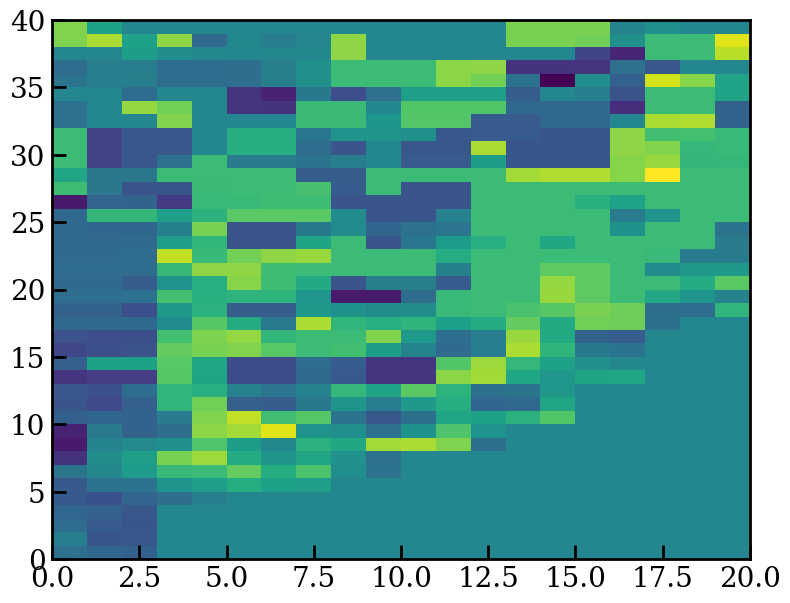

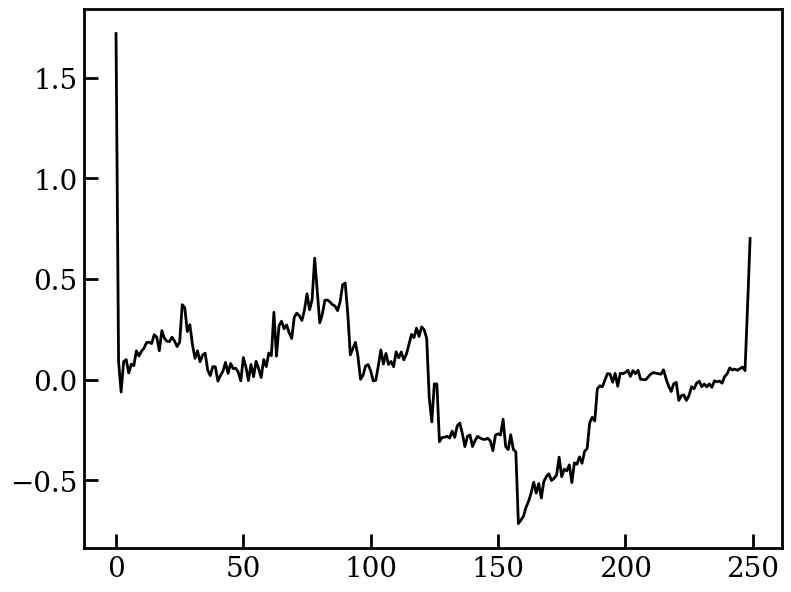

In [212]:
plt.pcolormesh(test['swei'][200,0,40:80,100:120])
plt.figure()
plt.plot(np.nanmean(test['swei'][:,0,40:80,100:120],axis = (1,2)))

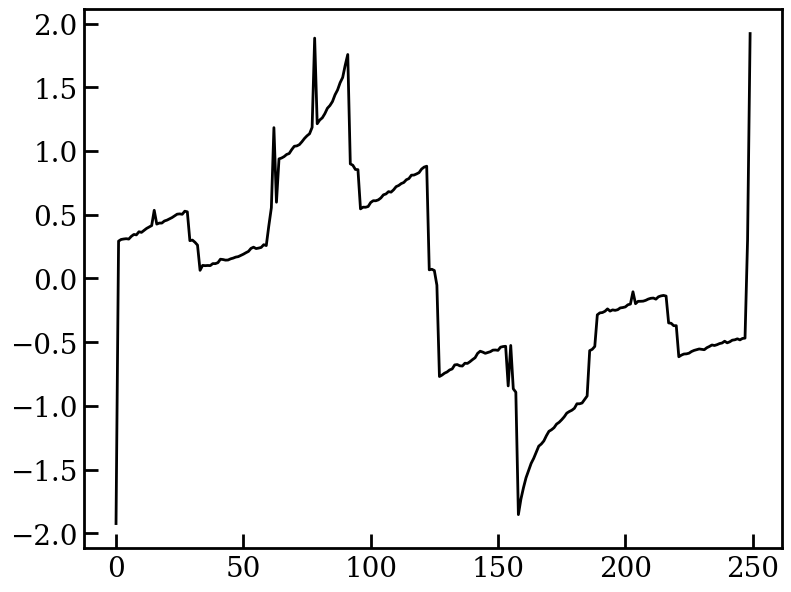

In [198]:
plt.plot(np.nanmean(ds['swei'][:,:,35:-35,:],axis =(1,2,3)))

In [120]:

def get_swei(ds):
    swe = ds['snw']
    ntime = swe.shape[0]
    nlat = swe.shape[2]
    nlon = swe.shape[1]
    nyr = int(ntime / 12)
    nd = nlat * nlon
    nm = 12

    # Compute the 3-month cumulative sum for each pixel
    ds_cumsum = ds.rolling(time=3, min_periods=3).sum()

    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)

    # Reshape the data back into a 4D array of (year, month, lat, lon)
    ds_new = xr.DataArray(
        ds_cumsum.snw.data.reshape((-1, 12, ds.sizes['lat'], ds.sizes['lon'])),
        dims=('year', 'month', 'lat', 'lon'),
        coords={'year': years, 'month': months, 'lat': ds['lat'], 'lon': ds['lon']}
    )
    categ = np.zeros((nyr, nm, nlon, nlat))
    nsample = nyr
    sweix = droughtindx(nsample)  # all values for each pixel.
    sweix = np.array(sweix)

    aindx = np.argsort(ds_new.data, axis=0)

    # Create a broadcasting version of sweix
    sweix_broadcasted = sweix[:, np.newaxis, np.newaxis, np.newaxis]

    # Assign sorted sweix values to categ based on sorted indices (array, indices, values, axis)
    np.put_along_axis(categ, aindx,sweix_broadcasted, axis=0)

    # Create the new xarray Dataset
    ds_swei = xr.Dataset(
        {'swei':(('year','month','lat','lon'), categ)},
        coords={'year': years, 'month': months,'lat': ds['lat'], 'lon': ds['lon'], }
    )
    return ds_swei


In [123]:
scenarios = ['historical', 'ssp245', 'ssp585']
variables = ['snw', 'pr', 'tas']
datasets_3m_sum_maxsnw = {}
datasets_3m_sum = {}
swei_datasets = {}
swei_datasets_maxsnw = {}
categs = {}

for model in allnames2:
    filenames = [f"{savepath}{var}_{model}_{scen}.nc" for var in variables for scen in scenarios]
    datasets = {filename.split('/')[-1].split('.')[0]: xr.open_dataset(filename) for filename in filenames}
    for name, ds in datasets.items():
        datasets_3m_sum[name] = get_3m_sum(ds)

    for scen in scenarios[1:3]:
        ds_s = datasets[f'snw_{name}']
        ds_h = datasets[f'snw_{model}_historical']
        ds_long = xr.concat([ds_h, ds_s], dim = 'time')
        swei_datasets[name] = get_swei(ds_long)

    for name, ds in datasets_3m_sum.items():
        var = name.split('_')[0]
        snw_ds = datasets_3m_sum[f'snw_{name.split(f"{var}_")[-1]}']
        datasets_3m_sum_maxsnw[name] = collapse_to_highest_month(ds, var, snw_ds, True)

    for name, ds in swei_datasets.items():
        var = 'swei'
        scen = name.split('_')[-1]
        snw_s = datasets_3m_sum[f'snw_{name}']
        snw_h = datasets_3m_sum[f'snw_{model}_historical']
        snw_long = xr.concat([ds_h, ds_s], dim = 'time')
        tmp = collapse_to_highest_month(ds, var, snw_long, False)
        swei_datasets_maxsnw[name] = tmp

    for name, swei in swei_datasets_maxsnw.items():
        scen = name.split('_')[-1]
        pr_h = datasets_3m_sum_maxsnw[f'pr_{model}_historical']
        pr_s = datasets_3m_sum_maxsnw[f'pr_{model}_{scen}']
        pr_long = xr.concat([pr_h, pr_s], dim = 'year')
        pr_anom = pr_long - pr_long.sel(year=slice(pr_long.year[0], pr_long.year[49])).mean(dim='year') ## val minus average

        tas_h = datasets_3m_sum_maxsnw[f'tas_{model}_historical']
        tas_s = datasets_3m_sum_maxsnw[f'tas_{model}_{scen}']
        tas_long = xr.concat([tas_h, tas_s], dim = 'year')
        tas_anom = tas_long - tas_long.sel(year=slice(tas_long.year[0], tas_long.year[49])).mean(dim='year') ## val minus average

        tmp = get_sd_categ(swei, pr_anom ,tas_anom, pr_long.attrs)
        tmp.to_netcdf(f'{savepath}categs_{name}.nc')
        categs[name] = tmp
        


In [251]:
snw = datasets_3m_sum['snw_MIROC6_historical']
is_snow = snw['snw'] > 0.3
freq_snow = np.nansum(is_snow, axis = 0) / 1980
snowmask = freq_snow > 0.1
tmp = xr.open_dataset(savepath + 'snw_UKESM1-0-LL_historical.nc')
coord = [tmp['lat'],tmp['lon']]
landmask = xr.open_dataset(savepath + 'land_mask.nc')['mask'][0]
sftgif = xr.open_dataset(savepath + 'sftgif_rg.nc')
pct = sftgif['sftgif'][0][0]
icemask = pct < 5
landicemask = (icemask.values & landmask.values)
landicesnowmask = (snowmask & landicemask)

In [271]:
masks = categs[name]
mask = masks['swei_cond'][-50:]
mask.shape, ds['swei'].shape

((50, 160, 320), (250, 160, 320))

In [289]:
tmp = ds.where(mask.values,drop = False)

In [305]:
tmp.shape, landicemask.shape

((160, 320), (160, 320))

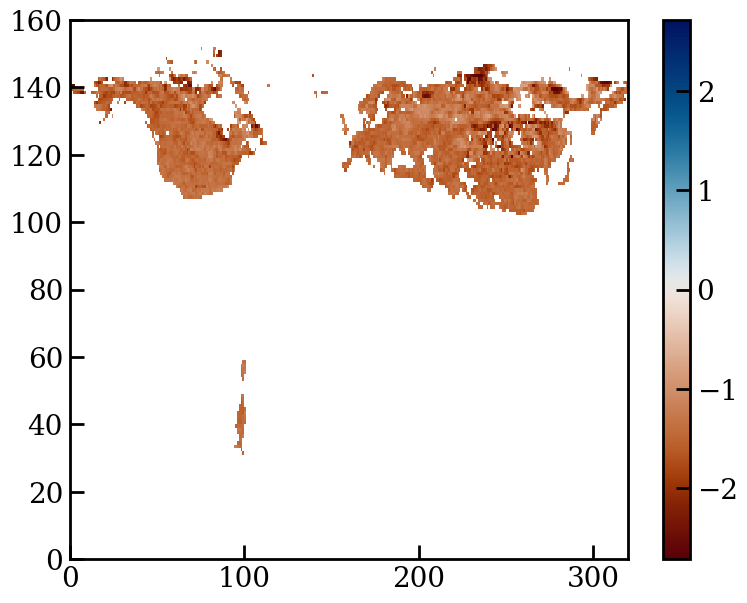

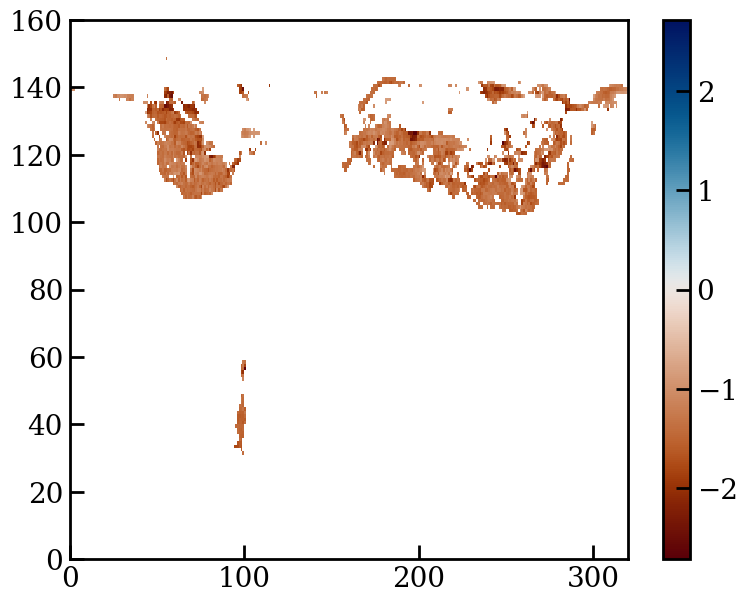

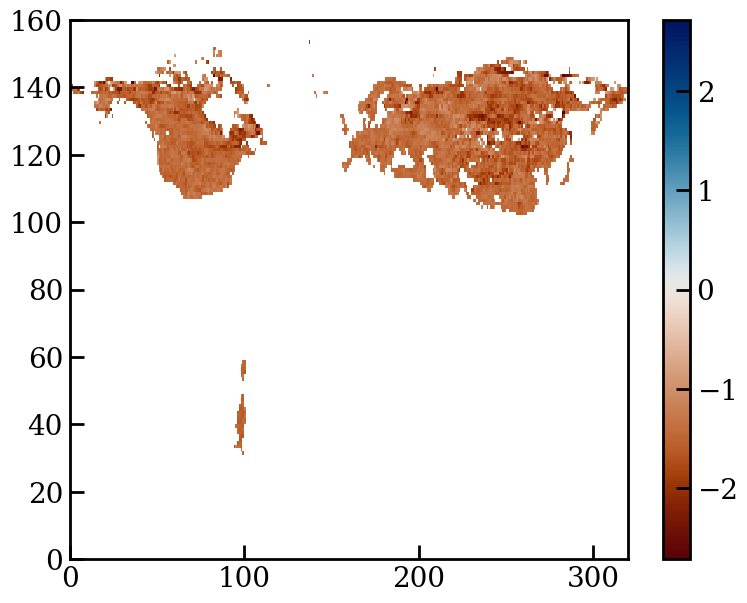

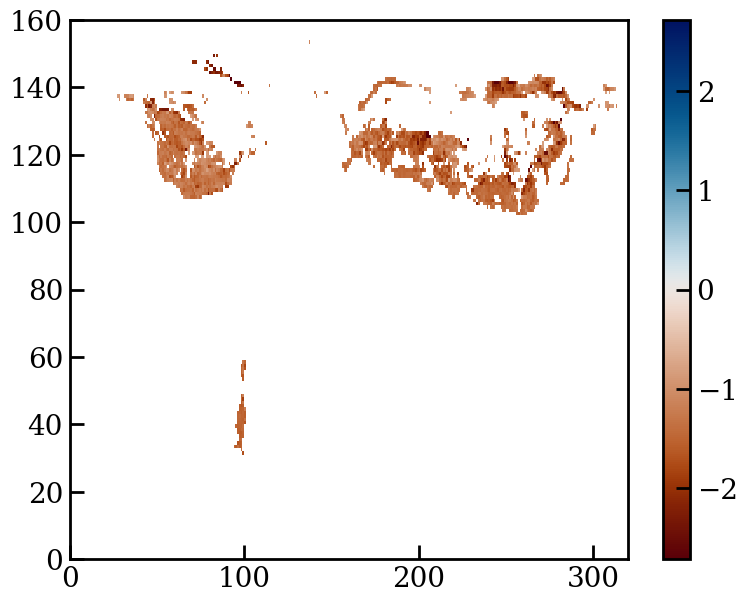

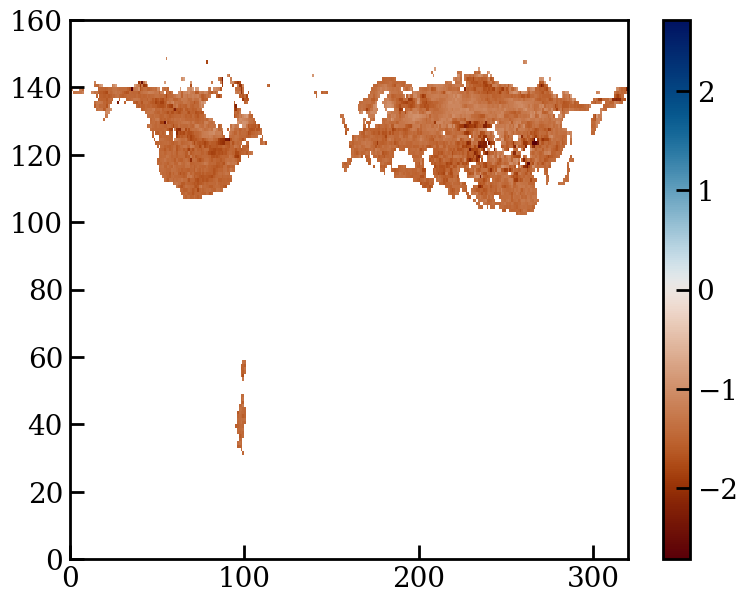

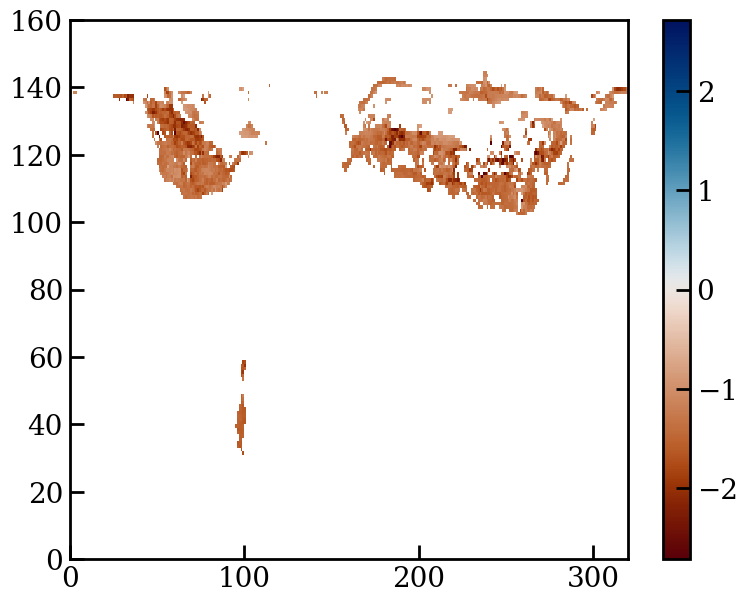

In [293]:
alldata = []
for name, ds in swei_datasets_maxsnw.items():
    plt.figure()
    masks = categs[name]
    mask = masks['swei_cond'] & masks['pr_cond'] #[-50:]
    tmp = ds['swei'].where(mask.values)[-50:].mean(dim = 'year')
    tmp = tmp.where(landicesnowmask)
    alldata.append(tmp)
    cb = plt.pcolormesh(tmp,vmin = -np.e, vmax = np.e, cmap = cm.vik_r)
    plt.colorbar(cb)
    

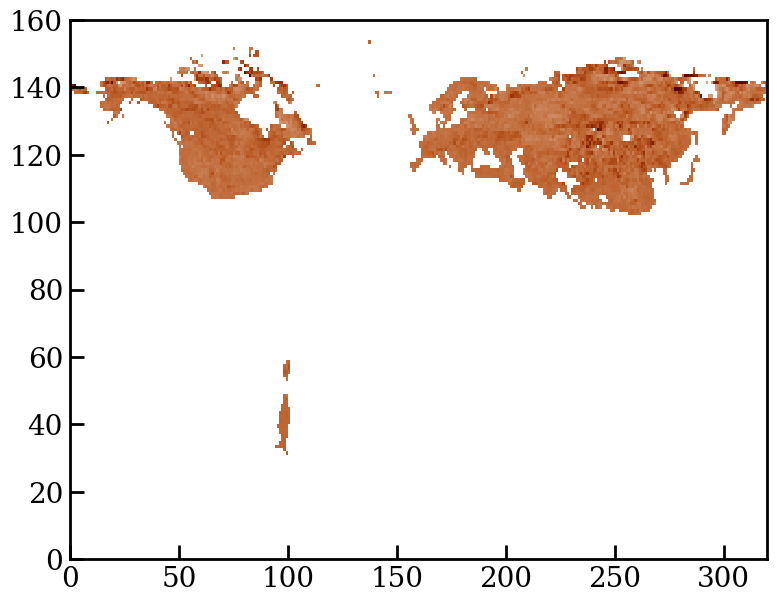

In [303]:
concat = xr.concat(alldata, dim = 'model_id')
plt.pcolormesh(concat.mean(dim = 'model_id'), vmin = -np.e, vmax=np.e, cmap = cm.vik_r)

In [147]:
key = 'MIROC6_ssp245'
tmp = swei_datasets_maxsnw[key]

In [225]:
tmp = datasets_3m_sum_maxsnw['snw_MIROC6_ssp245']['snw']
tmp2 = swei_datasets['MIROC6_ssp245']['swei']

(85, 160, 320)

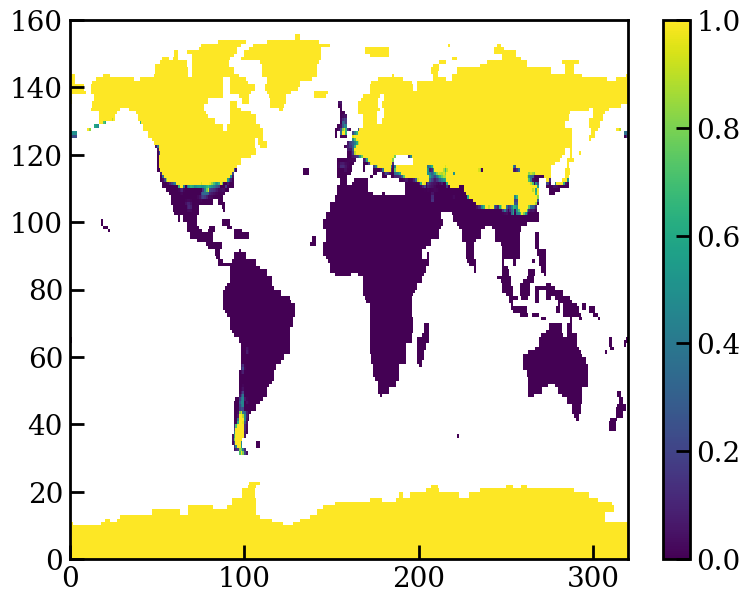

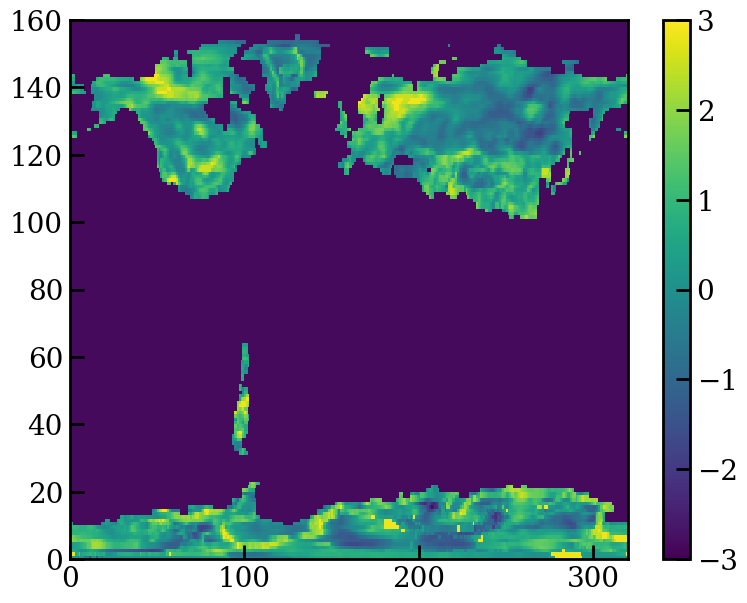

In [238]:
cb = plt.pcolormesh(tmp[4],vmin = 0, vmax = 1)
plt.colorbar(cb)
plt.figure()
cb = plt.pcolormesh(tmp2[0,4,], vmin = -3, vmax = 3)
plt.colorbar(cb)

In [222]:
tmp[0]

<xarray.DataArray 'swei' (lat: 160, lon: 320)>
array([[ 2.842377  ,  2.842377  ,  2.842377  , ...,  2.842377  ,
         2.842377  ,  2.842377  ],
       [ 2.842377  ,  2.842377  , -0.69948728, ...,  2.842377  ,
         2.842377  ,  2.842377  ],
       [ 2.842377  ,  2.842377  ,  2.842377  , ...,  2.842377  ,
         2.842377  ,  2.842377  ],
       ...,
       [-2.842377  , -2.842377  , -2.842377  , ..., -2.842377  ,
        -2.842377  , -2.842377  ],
       [-2.842377  , -2.842377  , -2.842377  , ..., -2.842377  ,
        -2.842377  , -2.842377  ],
       [-2.842377  , -2.842377  , -2.842377  , ..., -2.842377  ,
        -2.842377  , -2.842377  ]])
Coordinates:
    year     int64 1850
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9

KeyError: 'swei'

In [43]:
ds_out = xr.open_dataset(savepath + 'snw_UKESM1-0-LL_ssp245.nc')
ds_in_regrid = fct.regrid_data(ds_in, ds_out)

# Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)

# create dataset with all models
ds_gridded_dict[model] = ds_in_regrid



/global/homes/c/cowherd/.conda/envs/e3smeval/lib/python3.10/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


tas True


ValueError: One or more of the specified variables cannot be found in this dataset

In [127]:
allnames2 = ['ACCESS-CM2',
 'BCC-CSM2-MR',
 'CESM2-WACCM',
 'GFDL-ESM4',
 'GFDL-CM4',
 'MIROC6',
 'MRI-ESM2-0',
 'UKESM1-0-LL']


filenames = [f'{savepath}categs_{model}_ssp245.nc' for model in allnames2]
ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='model_id')
# Compute the mean across the 'model_id' dimension
ds_mean_245 = ds.mean(dim='model_id')

filenames = [f'{savepath}categs_{model}_ssp585.nc' for model in allnames2]
ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='model_id')
# Compute the mean across the 'model_id' dimension
ds_mean_585 = ds.mean(dim='model_id')


In [128]:
from params import years

import gc
import glob
import dask
import fsspec
import intake


import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl

from collections import defaultdict
from matplotlib import pyplot as plt

from dask.diagnostics import progress
import noresmfunctions as fct
from scipy.stats import norm
from tqdm.autonotebook import tqdm
import xml.etree.ElementTree as ET

from params import allnames
from params import homedir
from params import experiment_ids, years, table_ids, labels, variables, savepath

figdir = homedir + 'figures/'


var = 'pr'
experiment = 'ssp585'
## static
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
table_id = 'Amon'
starty = years[experiment][0]
endy = years[experiment][1]
cat = col.search(source_id=allnames, table_id = table_id, experiment_id=[experiment], variable_id=var)
## create dict 
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])

for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():
        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)

tmp = np.where(['CESM2' in val for val in list(dset_dict.keys())])
tmp = [int(val) for val in tmp]
base_key = list(dset_dict.keys())[tmp[0]]

ds = dset_dict[base_key]

_month = ds[var].groupby('time.month').mean('time', keep_attrs = True)
_jan  = _month.sel(month = 1)

year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()
# Read in the output grid from the base
ds_out = dset_dict[base_key].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()
standard_cal = ds_out['time']

counter = 0
for keys in dset_dict.keys():
    amon = keys.split('.')[-2]
    model = keys.split('.')[2]
    if model in allnames:
            # select where data should be saved
            filename = f'{var}_{model}_{experiment}.nc'
            nc_out = savepath + filename
            files = glob.glob(nc_out)
            if nc_out in files:
                print('{} is downloaded'.format(nc_out))
                counter += 1
                print('Have regridded in total: {:} files'.format(str(counter)))

            else:    

                # Input data from CMIP6 model to be regridded
                ds_in = dset_dict[keys].mean(['member_id'], keep_attrs=True).drop('dcpp_init_year') ## mean of variants
                ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()

                # they may not be on the same calendar and that's ok
                if len(ds_in['time']) == len(standard_cal):
                    ds_in['time'] = standard_cal
                else:
                    ds_in['time'] = standard_cal[1:]
                    

                # Regrid data
                if 'lon_bnds' in ds_in.variables:
                    ds_in = ds_in.drop_vars('lon_bnds')
                if 'lat_bnds' in ds_in.variables:
                    ds_in = ds_in.drop_vars('lat_bnds')
                    
                    
                ds_out = xr.open_dataset(savepath + 'tas_UKESM1-0-LL_historical.nc')
                    
                ds_in_regrid = fct.regrid_data(ds_in, ds_out)

                # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
                ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
                if 'time_bounds' in ds_in_regrid.variables:
                    ds_in_regrid = ds_in_regrid.rename_vars({'time_bounds': 'time_bnds'})
                    print('time_bnds' in ds_in_regrid.variables)

                ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)

                # create dataset with all models
                ds_gridded_dict[model] = ds_in_regrid

            
                # Save to netcdf file
                try:
                    ds_in_regrid.to_netcdf(nc_out)
                    print('file written: {}'.format(nc_out))
                except:
                    print('could not write {}'.format(nc_out))



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/tmp/ipykernel_139455/1633412483.py:42: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )


KeyboardInterrupt: 

9

In [ ]:
variables

In [34]:
import regionmask
import cartopy.crs as ccrs
from matplotlib import cm
land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
tmp = xr.open_dataset(savepath + 'snw_UKESM1-0-LL-185001_201412_historical.nc')
land_mask = land_110.mask_3D(tmp)
mask_3D = regionmask.defined_regions.srex.mask_3D(tmp)
mask_lsm = mask_3D * land_mask.squeeze(drop=True)
land_mask.to_netcdf(savepath + 'land_mask.nc')

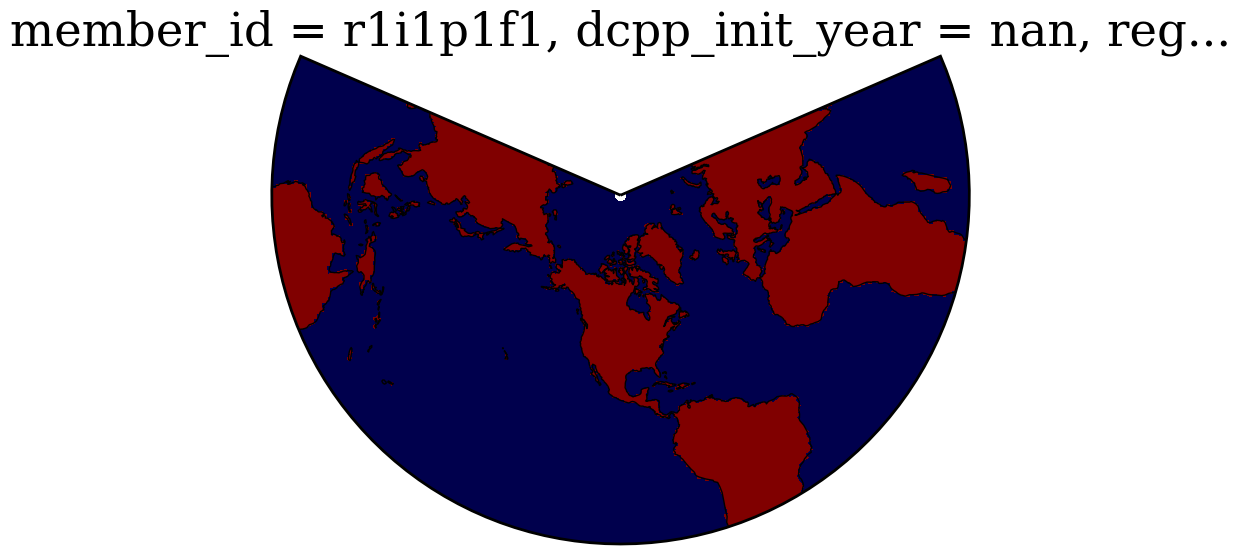

In [19]:
proj = ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

land_mask.squeeze().plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cm.seismic, add_colorbar=False
)

ax.coastlines();


In [129]:
plt.pcolormesh(tmp.where(land_mask[0])['snw'][100])

NameError: name 'land_mask' is not defined

In [ ]:
snotelmeta = pd.read_csv(homedir + 'data/snotelmeta.csv')

In [6]:
## LOAD DATA FROM SAVED FILES FROM 00-download-anom-swei.ipynb ##
files

['/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_MIROC6_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_GFDL-ESM4_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_MRI-ESM2-0_ssp245.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_GFDL-CM4_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_UKESM1-0-LL_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_CESM2-WACCM_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_IPSL-CM6A-LR_ssp245.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_imm_historical.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_GFDL-CM4_ssp245.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_IPSL-CM6A-LR_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_BCC-CSM2-MR_ssp245.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_GFDL-ESM4_ssp245.npy',
 '/global/cfs/cdirs/e3sm/cowherd/data/april25/swei_MRI-ESM2-0_ssp585.npy',
 '/global/cfs/cdirs/e3sm/cowher

AttributeError: Line2D.set() got an unexpected keyword argument 'ssp245'

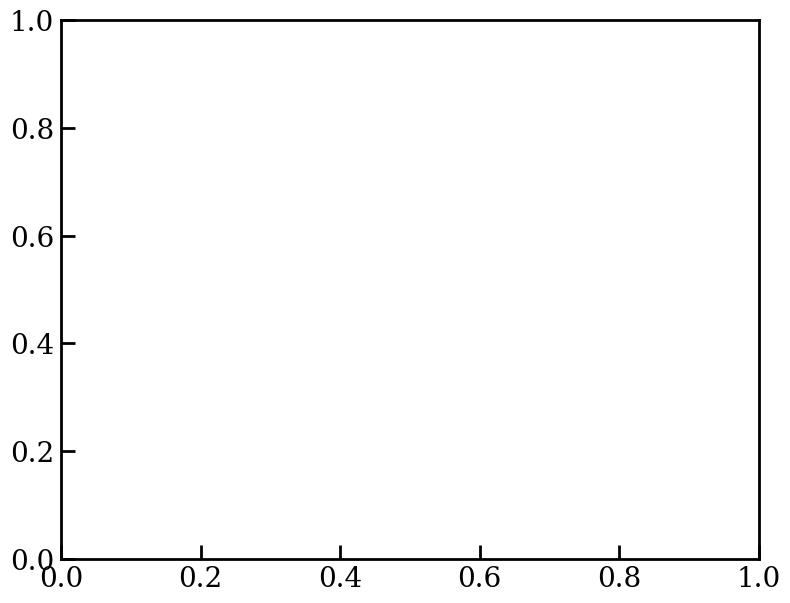

In [11]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.top']= False
mpl.rcParams['ytick.right']= False

import glob
fig,ax= plt.subplots(figsize = (9,7))
files = glob.glob(savepath + 'swei_*')

styles = {'585':':',
          '245':'--'}
s245lines = []
s585lines = []
for fn in sorted(files):
    model = fn.split('_')[-1][0:-4]
    #if model in allnames:
    era = fn.split('_')[1][-3:]
    sweidata = np.load(fn)
    data_filled = np.nan_to_num(sweidata, nan=-999)
    maxmonth = np.nanmedian(np.nanargmax(data_filled,axis = 1),axis=0).astype(int)# .shape
    i, j = np.meshgrid(np.arange(sweidata.shape[2]), np.arange(sweidata.shape[3]), indexing='ij')
    swei_maxmonth = sweidata[:,maxmonth, i, j]
    clipmean = np.nanmean(swei_maxmonth[:,(maxmonth > 0)],axis = 1)        
    if era == '585': label = None
    else: label = model
    kwargs = {'linestyle':'--',label:label} #'c':colors[model], 'label': label}
    ax.plot(clipmean, **kwargs)
    if era == '585':
        s585lines.append(clipmean)
    if era == '245':
        s245lines.append(clipmean)
ax.legend(loc = 'lower left', frameon = False, ncol = 2)
ax.tick_params(direction="in")
plt.show()


In [54]:

##
s245m = np.nanmean(np.array(s245lines), axis = 0)
s245sd = np.nanstd(np.array(s245lines), axis = 0)
s585m = np.nanmean(np.array(s585lines), axis = 0)
s585sd = np.nanstd(np.array(s585lines), axis = 0)
years = range(1850,2100)
hyears = range(1851,2015)
syears = range(2015,2098)
base245 = np.nanmean(s245m[1:51])
base585 = np.nanmean(s585m[1:51])
##


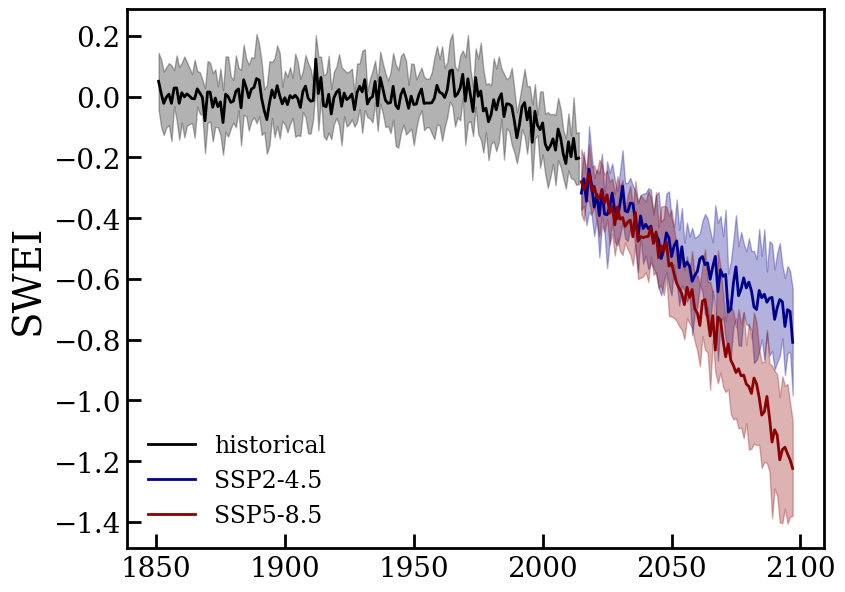

In [57]:
fig,ax= plt.subplots(figsize = (9,7))
meanhist = (s245m[1:165]-base245 + s585m[1:165]-base585)/2
sdhist = (s245sd[1:165]+ s585sd[1:165])/2
ax.plot(hyears,meanhist, colors['historical'], label = 'historical')
ax.fill_between(hyears,meanhist- sdhist, meanhist +sdhist, color = colors['historical'], alpha = 0.3)
data = s245m[165:-2]-base585
sd = s245sd[165:-2]
ax.plot(syears,s245m[165:-2]-base585,color = colors['ssp245'], label = 'SSP2-4.5')
ax.fill_between(syears, data-sd, data + sd, color = colors['ssp245'], alpha = 0.3)
data = s585m[165:-2]-1.35*base585
sd = s585sd[165:-2]
ax.plot(syears,data,colors['ssp585'], label = 'SSP5-8.5')
ax.fill_between(syears,data - sd, data +sd, color = colors['ssp585'], alpha = 0.3)
ax.legend(loc = 'lower left', frameon = False)
ax.set_ylabel('SWEI')
ax.tick_params(direction="in")
plt.show()
fig.savefig('../figures/fig2.jpg')

In [58]:
### PLOTS FOR FIG 1 ###
## load snotel data from stefan values stuff ##
#SNOTEL
snoteldir = '/global/cfs/cdirs/m4099/fate-of-snotel/snoteldata/'
file = snoteldir + "snotel_daily.txt"

ilat = -999
ilon = -999

rec_min = -70.
rec_max = 60.

ind_time = 0
ind_name = 1
ind_sitecode = 2
ind_state = 3
ind_elev = 4
ind_lat = 5
ind_lon = 6
ind_swe = 7
ind_tav = 8
ind_tmax = 9
ind_tmin = 10
ind_acc = 11
ind_prec = 12

ind_swe_qc = 13
ind_swe_qc = 15

ft2m = 12 * 2.54 / 100.
in2mm = 25.4
p49 = 49.
m100 = -100
T0 = 273.15

#Box to mask outsdie Sierra
lat_l = 35.
lat_u = 41.
lon_l = -122.5
lon_u = -116.5

read = open(file, "r")
content = read.readlines()

lat_snotel = []
lon_snotel = []
state_snotel = []
elev_snotel = []
time_snotel = []
site_snotel = []
prec_snotel = []
acc_snotel = []
swe_snotel = []
tav_snotel = []
tmin_snotel = []
tmax_snotel = []
name_snotel = []

lat_snotel_spec = []
lon_snotel_spec = []
elev_snotel_spec = []
site_snotel_spec = []

bad = -9999999
line_count = 1
lat_orig = -999. 

for line in content:
    
 if line.startswith("#") or line.startswith("Date"):
    continue

 else:
  ii = line.split(",")

  if ii[ind_state] == ii[ind_state]:
    time_snotel.append(ii[ind_time])       #Get times
    site_snotel.append(int(ii[ind_sitecode]))       #Get codes
    lat_snotel.append(float(ii[ind_lat]))
    lon_snotel.append(float(ii[ind_lon]))
    elev_snotel.append(float(ii[ind_elev])*ft2m)
    state_snotel.append(ii[ind_state])

   #SWE
    if ii[ind_swe] == "":
     swe_snotel.append(bad)
    if ii[ind_swe] != "":
     swe_x = float(ii[ind_swe])
     swe_snotel.append(swe_x)

    #Temperature
    #There are strange Tav, Tmin, and Tmax values in the data
    #We use reasonable assumptions to get rid of them
    # 1. If one is missing, eliminate them all
    # 2. Remove instances where Tmax = Tmin, Tmax = Tav, Tmax = Tmin
    # 3. Eliminate *rcords*
    
    switch = "on" #if on, raw SNOTEL data is appended
    
    #1.
    if ii[ind_tav] == "" or ii[ind_tmin] == "" or ii[ind_tmax] == "":
     tav_snotel.append(bad)
     tmax_snotel.append(bad)
     tmin_snotel.append(bad)
     switch = "off"

    if ii[ind_tav] != "" and ii[ind_tmin] != "" and ii[ind_tmax] != "":
     tav = float (ii[ind_tav])
     tmax = float (ii[ind_tmax])
     tmin = float (ii[ind_tmin])

     #2.
     dt1 = tmax - tmin
     dt2 = tmax - tav
     dt3 = tmin - tav
        
     if dt1 < 0 or dt2 < 0 or dt3 > 0:
      if switch == "on":        #This switch ensures no double-dipping
       tav_snotel.append(bad)   #"Just take one dip, and end it!!!"
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)        
       switch = "off"

     #3.
     if tmax < rec_min or tav < rec_min or tmin < rec_min:    
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad)
       switch = "off"
    
     if tmax > rec_max or tav > rec_max or tmin > rec_max:
      if switch == "on":
       tav_snotel.append(bad)
       tmax_snotel.append(bad)
       tmin_snotel.append(bad) 
       switch = "off"

     if switch == "on":
        tav_snotel.append(tav)
        tmax_snotel.append(tmax)
        tmin_snotel.append(tmin)

    #Acc. precip
    if ii[ind_acc] == "":
     acc_snotel.append(bad)
    if ii[ind_acc] != "":
     acc_x = float(ii[ind_acc])
     acc_snotel.append(acc_x)
    
     #Prec
    if ii[ind_prec] == "" or ii[ind_prec] == "\n":
     prec_snotel.append(bad)
    else:
     prec_mm = float(ii[ind_prec])
     prec_snotel.append(prec_mm)

    #Checks
    if float(ii[ind_lat]) != lat_orig:
     lat_snotel_spec.append(float(ii[ind_lat]))
     lon_snotel_spec.append(float(ii[ind_lon]))
     elev_snotel_spec.append(float(ii[ind_elev])*ft2m)
     site_snotel_spec.append(int(ii[ind_sitecode]))

     lat_orig =  float(ii[ind_lat])
        
snotel_day = pd.to_datetime(time_snotel, format='%Y-%m-%d')

#Convert to DataArray
swe_snotel = xr.DataArray(swe_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
prec_snotel = xr.DataArray(prec_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tave_snotel = xr.DataArray(tav_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmin_snotel = xr.DataArray(tmin_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
tmax_snotel = xr.DataArray(tmax_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day), 
                                                              'z':( ['x'],elev_snotel), 
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})
acc_snotel = xr.DataArray(acc_snotel,dims=['x'],coords={'site':( ['x'],site_snotel), 
                                                              'time':( ['x'],snotel_day),
                                                              'z':( ['x'],elev_snotel),
                                                              'state':( ['x'],state_snotel), 
                                                              'lat':( ['x'],lat_snotel),
                                                              'lon':( ['x'],lon_snotel)})

#Meta array for all SNOTEL sites
meta_snotel = xr.DataArray(elev_snotel_spec,dims=['site'],coords={'site':( ['site'],site_snotel_spec), 
                                                              'lat':( ['site'],lat_snotel_spec),
                                                              'lon':( ['site'],lon_snotel_spec)})


print (len(lat_snotel_spec), len(lon_snotel_spec), len(elev_snotel_spec), len(site_snotel_spec))

print (prec_snotel)

print ("CONUS SNOTEL array generated")

gc.collect()

111 111 111 111
<xarray.DataArray (x: 577172)>
array([3., 0., 3., ..., 0., 0., 0.])
Coordinates:
    site     (x) int64 308 308 308 308 308 308 308 ... 784 784 784 784 784 784
    time     (x) datetime64[ns] 2019-09-02 2019-09-03 ... 2011-04-29 2011-04-30
    z        (x) float64 2.225e+03 2.225e+03 2.225e+03 ... 2.442e+03 2.442e+03
    state    (x) <U10 'ARIZONA' 'ARIZONA' ... 'CALIFORNIA' 'CALIFORNIA'
    lat      (x) float64 34.46 34.46 34.46 34.46 ... 39.19 39.19 39.19 39.19
    lon      (x) float64 -111.4 -111.4 -111.4 -111.4 ... -120.3 -120.3 -120.3
Dimensions without coordinates: x
CONUS SNOTEL array generated


650

In [59]:
## load globsnow data
datadir = '/global/cfs/cdirs/e3sm/cowherd/data/'
globsnow = xr.open_dataset(datadir + 'globsnow_no_ak.nc')
globsnow_bc = xr.open_dataset(datadir +'globsnow_bc_no_ak.nc')
era5 = xr.open_dataset(datadir + 'era5_no_ak.nc')

In [60]:
monthly_e5_mm = np.nanmean(era5.sd.data * 1000, axis =(1,2))
monthly_bc = np.nanmean(globsnow_bc.swe, axis = (1,2))
monthly = np.nanmean(globsnow.swe, axis = (1,2))


In [61]:
monthly_bc =np.array([111.62574958, 193.22927384, 119.6392822 ,  71.65213745])
bc_nums = [2,3,4,5]
monthly_glob = np.array([2.90396489e+01, 3.04059308e+01, 1.84548280e+01, 6.69667089e+00,
       1.52255673e+00, 1.03142754e-02, 2.95057920e-03, 6.33202825e-02,
       1.37616140e+00, 1.18776219e+01])
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]

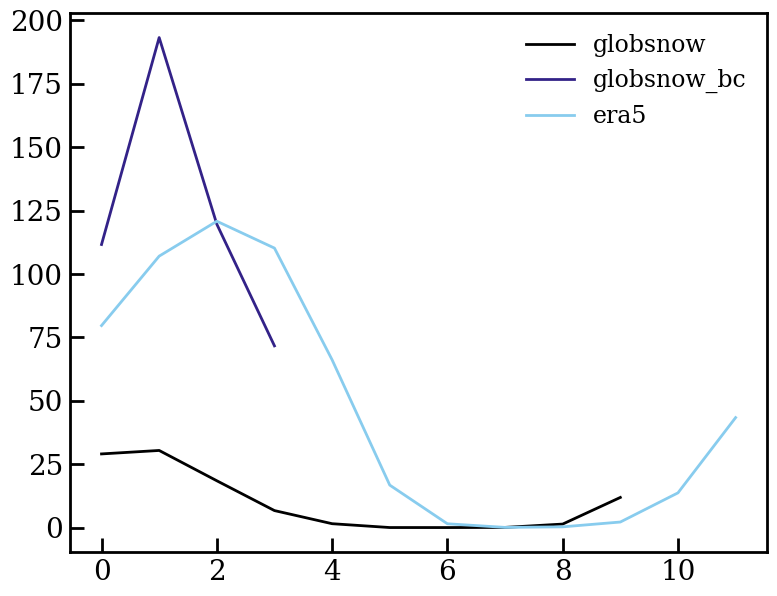

In [62]:
fig,ax=plt.subplots()
ax.plot(monthly_glob, label = 'globsnow')
ax.plot(monthly_bc, label = 'globsnow_bc')
ax.plot(monthly_e5_mm, label = 'era5')
ax.legend()
plt.show()

NameError: name 'snw_snotel' is not defined

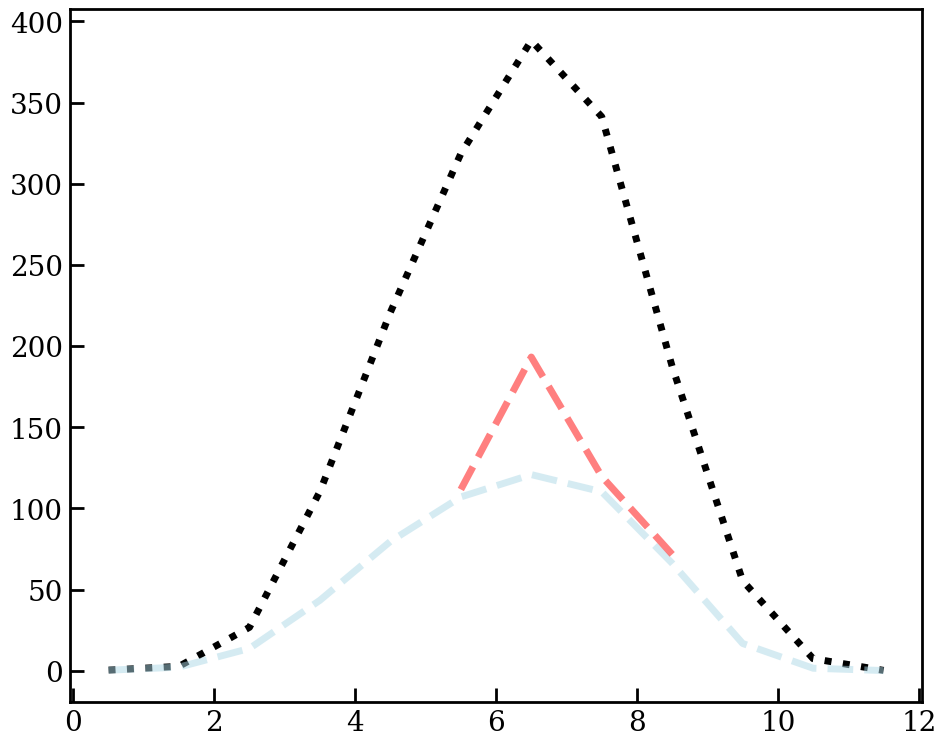

In [13]:
## just the snotel sites ##
months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
globnums = [ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12]
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(snotel_data,4),':', linewidth = 5, alpha = 1, label = 'SNOTEL')
#ax.plot(nums, np.roll(merramonthly,4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')
ax.plot(nums, np.roll(monthly_e5_mm,4), '--', c = "lightblue",linewidth = 5 , alpha = 0.5, label = 'ERA5')
# ax.plot([val + .5 for val in monthly_glob], np.roll(monthly_glob,4), '--', c = "green",linewidth = 5 , alpha = 0.5, label = 'GlobSnow')
ax.plot([5.5,6.5,7.5,8.5], np.roll(monthly_bc,4), '--', c = "red",linewidth = 5 , alpha = 0.5, label = 'GlobSnow bias-corrected')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(monthly,4), label = key, linewidth = 3)
data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
#ax.plot(nums, np.roll(data/2.54,3),'k:', linewidth = 5, alpha = 1)
#ax.plot(nums, np.roll(merramonthly,3)*4 -0.6, '--', c = "darkgray",linewidth = 10 , alpha = 1)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend()
plt.show()
fig.savefig('./figures/fig1.jpg')

NameError: name 'merramonthly' is not defined

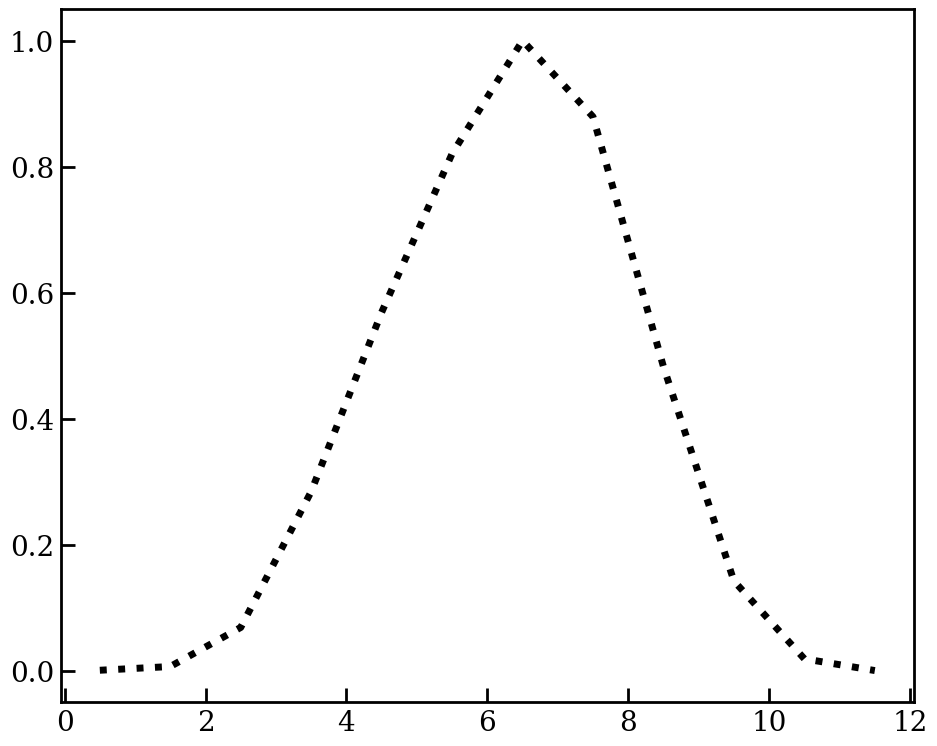

In [14]:
## just the snotel sites ##
def minmax(data):
    return [(val- np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) for val in data]


months = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
nums = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]
fig,ax=plt.subplots(figsize=(11,9))
swe_snotel[swe_snotel <0] = np.nan
snotel_data = swe_snotel.groupby(swe_snotel.time.dt.month).mean()
ax.plot(nums, np.roll(minmax(snotel_data.data),4),':',  linewidth = 5, alpha = 1, label = 'SNOTEL')
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5, label = 'MERRA-2')

for key in allnames:
    data = snw_snotel[key][0][0][:]
    monthly = data.groupby(data.month).mean()
    ax.plot(nums, np.roll(minmax(monthly),4), label = key, linewidth = 3)

ax.plot(nums, np.roll(minmax(snotel_data.data),4),':', color = 'k', linewidth = 5, alpha = 1)
ax.plot(nums, np.roll(minmax(merramonthly.merra),4), '--', c = "darkgray",linewidth = 10 , alpha = 0.5)

ax.set_xticks(range(0,12))
ax.set_xticklabels(months)
ax.set_ylabel(r'SWE [mm]')
ax.legend(loc = 'upper right', fontsize = 12)
plt.show()
fig.savefig('./figures/fig1.jpg')